# 全区域

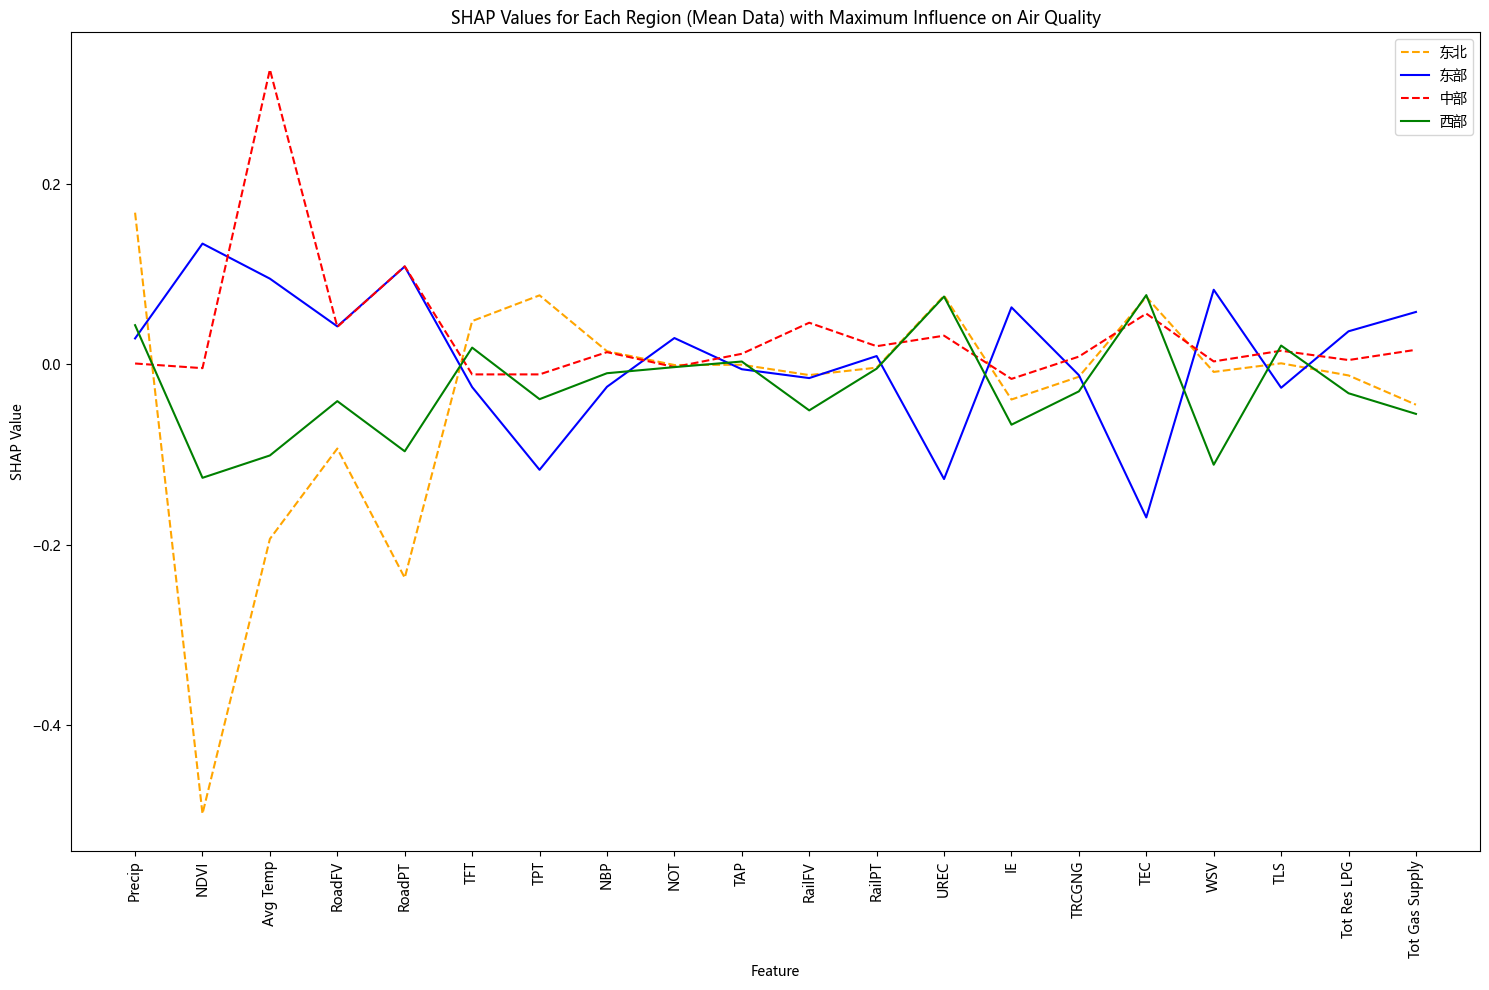

In [22]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 读取 Excel 文件
yaqem_df = pd.read_excel("YAQEM.xlsx")
xne_df = pd.read_excel("XNE.xlsx")
xtn_df = pd.read_excel("XTN.xlsx")
xec_df = pd.read_excel("XEC.xlsx")

# 选择空气质量相关特征进行 PCA 降维
air_quality_features = ["CO", "NO2", "O3", "PM2_5", "PM10", "SO2"]
yaqem_filtered = yaqem_df[air_quality_features].dropna()

scaler = StandardScaler()
yaqem_scaled = scaler.fit_transform(yaqem_filtered)

pca = PCA(n_components=1)
yaqem_pca = pca.fit_transform(yaqem_scaled)

yaqem_df["AirQualityIndex"] = yaqem_pca

# 确保 `year` 列唯一，删除重复列
xne_df = xne_df.loc[:, ~xne_df.columns.duplicated()]
xtn_df = xtn_df.loc[:, ~xtn_df.columns.duplicated()]
xec_df = xec_df.loc[:, ~xec_df.columns.duplicated()]
yaqem_df = yaqem_df.loc[:, ~yaqem_df.columns.duplicated()]

# 直接指定 20 个数据特征列名，并修正 RFV -> RoadFV, RPT -> RoadPT
feature_columns = [
    "Precip", "NDVI", "Avg Temp",  # 自然环境 (XNE)
    "RoadFV", "RoadPT", "TFT", "TPT", "NBP", "NOT", "TAP", "RailFV", "RailPT",  # 交通 (XTN)
    "UREC", "IE", "TRCGNG", "TEC", "WSV", "TLS", "Tot Res LPG", "Tot Gas Supply"  # 能源 (XEC)
]

# 合并 X 数据（自然环境、交通、能源）
x_data = xne_df.merge(xtn_df, on=["city", "year"], how="outer")
x_data = x_data.merge(xec_df, on=["city", "year"], how="outer")

# 确保 `year` 只出现一次
x_data = x_data.loc[:, ~x_data.columns.duplicated()]

# 仅保留指定的 20 个特征
x_data = x_data[["city", "year"] + feature_columns]

# 合并 X 和 Y 数据（使用 left join 确保数据不丢失）
final_data = yaqem_df[["city", "year", "AirQualityIndex", "quyu"]].merge(x_data, on=["city", "year"], how="left")

# 使用 fillna(0) 填充缺失值，确保 X 数据完整
final_data_cleaned = final_data.fillna(0)

# 选择特征和目标变量
X = final_data_cleaned[feature_columns]
Y = final_data_cleaned["AirQualityIndex"]

# 处理非数值列
X = X.select_dtypes(include=[np.number])

# 强制转换所有特征列为数值类型
for col in feature_columns:
    final_data_cleaned[col] = pd.to_numeric(final_data_cleaned[col], errors="coerce")

# 获取现有的特征并确保包含所有 20 个特征
full_feature_columns = feature_columns  # 确保这是 20 个特征

# 确保在 SHAP 计算时所有特征都出现在数据中
# 如果有缺失值，填充为 0
X_filled = final_data_cleaned[full_feature_columns].fillna(0)

# 训练 XGBoost 模型
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X_filled, Y)

# 计算 SHAP 值
explainer = shap.Explainer(model, X_filled)
shap_values = explainer(X_filled)

# 获取区域信息
regions = final_data_cleaned["quyu"].unique()

# 区域颜色映射
region_colors = {
    '东部': 'blue',
    '西部': 'green',
    '东北': 'orange',
    '中部': 'red'
}

# 找到正向影响最大的区域
max_shap_value = -np.inf
max_shap_region = None

# 绘制 SHAP 值折线图
plt.figure(figsize=(15, 10))

for i, region in enumerate(regions):
    # 获取该区域的数据
    region_data = final_data_cleaned[final_data_cleaned["quyu"] == region]
    
    # 获取 SHAP 值
    region_indices = region_data.index
    region_shap_values = shap_values.values[region_indices]
    
    # 计算每个特征的平均 SHAP 值
    avg_shap_values = np.mean(region_shap_values, axis=0)
    
    # 找到影响最大的区域
    if np.max(avg_shap_values) > max_shap_value:
        max_shap_value = np.max(avg_shap_values)
        max_shap_region = region
    
    # 绘制该区域的折线图
    linestyle = '--' if region == max_shap_region else '-'  # 正向影响最大的区域用虚线
    plt.plot(full_feature_columns, avg_shap_values, label=region, color=region_colors.get(region, 'gray'), linestyle=linestyle)

# 设置图形标题、标签和图例
plt.title("SHAP Values for Each Region (Mean Data) with Maximum Influence on Air Quality")
plt.xlabel("Feature")
plt.ylabel("SHAP Value")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


# 东部区域

C:\Users\huawei\AppData\Local\Temp\ipykernel_22888\3222044543.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  city_colors = plt.cm.get_cmap("tab10", len(east_region_cities))


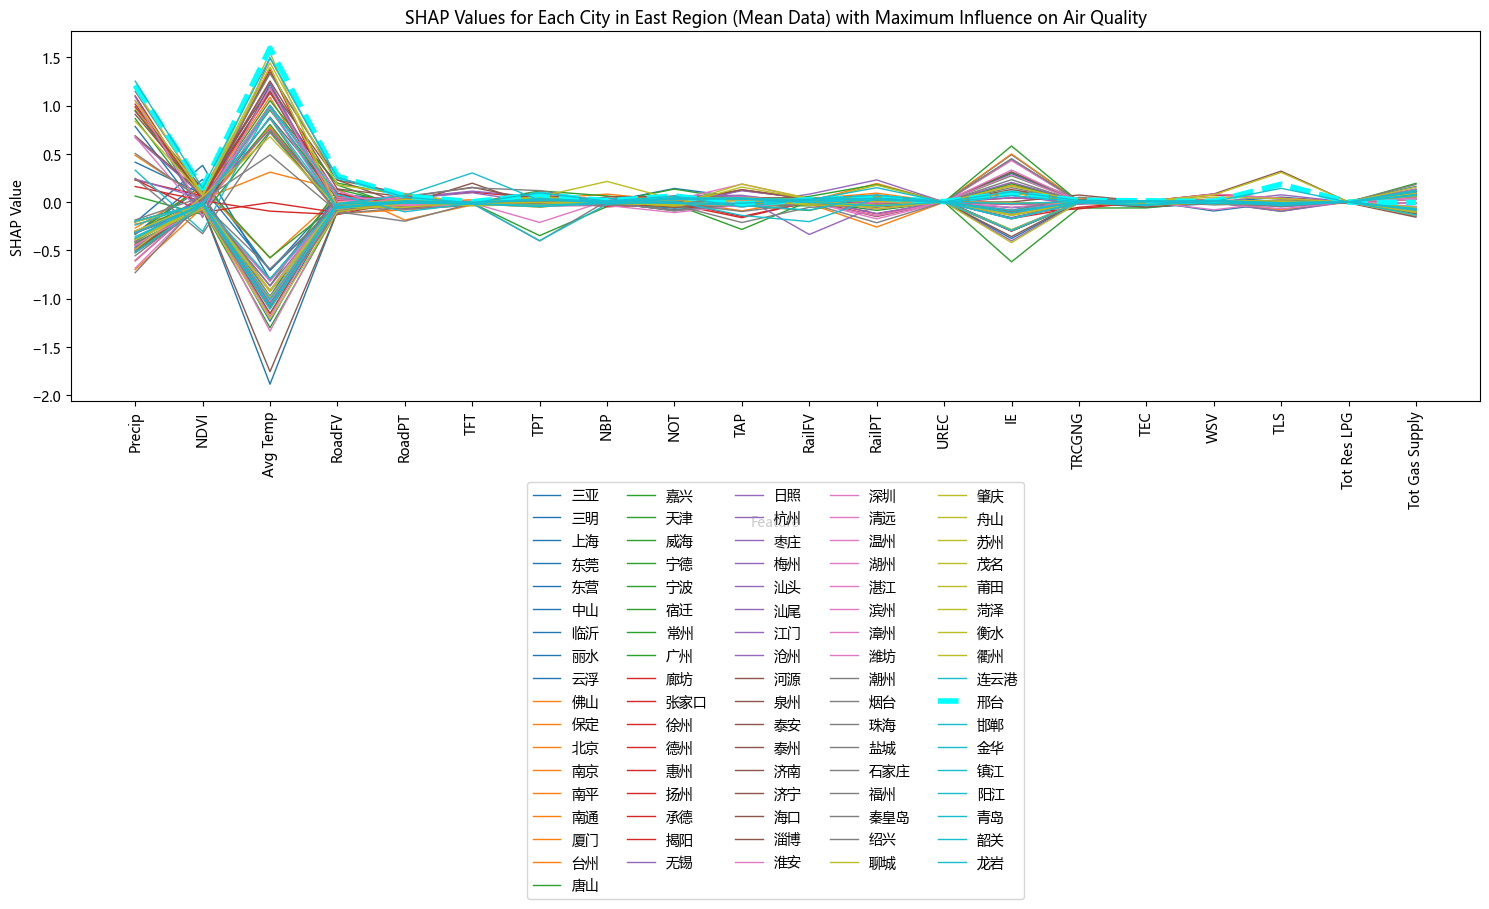

In [57]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 读取 Excel 文件
yaqem_df = pd.read_excel("YAQEM.xlsx")
xne_df = pd.read_excel("XNE.xlsx")
xtn_df = pd.read_excel("XTN.xlsx")
xec_df = pd.read_excel("XEC.xlsx")

# 选择空气质量相关特征进行 PCA 降维
air_quality_features = ["CO", "NO2", "O3", "PM2_5", "PM10", "SO2"]
yaqem_filtered = yaqem_df[air_quality_features].dropna()

scaler = StandardScaler()
yaqem_scaled = scaler.fit_transform(yaqem_filtered)

pca = PCA(n_components=1)
yaqem_pca = pca.fit_transform(yaqem_scaled)

yaqem_df["AirQualityIndex"] = yaqem_pca

# 确保 `year` 列唯一，删除重复列
xne_df = xne_df.loc[:, ~xne_df.columns.duplicated()]
xtn_df = xtn_df.loc[:, ~xtn_df.columns.duplicated()]
xec_df = xec_df.loc[:, ~xec_df.columns.duplicated()]
yaqem_df = yaqem_df.loc[:, ~yaqem_df.columns.duplicated()]

# 直接指定 20 个数据特征列名，并修正 RFV -> RoadFV, RPT -> RoadPT
feature_columns = [
    "Precip", "NDVI", "Avg Temp",  # 自然环境 (XNE)
    "RoadFV", "RoadPT", "TFT", "TPT", "NBP", "NOT", "TAP", "RailFV", "RailPT",  # 交通 (XTN)
    "UREC", "IE", "TRCGNG", "TEC", "WSV", "TLS", "Tot Res LPG", "Tot Gas Supply"  # 能源 (XEC)
]

# 合并 X 数据（自然环境、交通、能源）
x_data = xne_df.merge(xtn_df, on=["city", "year"], how="outer")
x_data = x_data.merge(xec_df, on=["city", "year"], how="outer")

# 确保 `year` 只出现一次
x_data = x_data.loc[:, ~x_data.columns.duplicated()]

# 仅保留指定的 20 个特征
x_data = x_data[["city", "year"] + feature_columns]

# 合并 X 和 Y 数据（使用 left join 确保数据不丢失）
final_data = yaqem_df[["city", "year", "AirQualityIndex", "quyu"]].merge(x_data, on=["city", "year"], how="left")

# 使用 fillna(0) 填充缺失值，确保 X 数据完整
final_data_cleaned = final_data.fillna(0)

# 选择特征和目标变量
X = final_data_cleaned[feature_columns]
Y = final_data_cleaned["AirQualityIndex"]

# 处理非数值列
X = X.select_dtypes(include=[np.number])

# 强制转换所有特征列为数值类型
for col in feature_columns:
    final_data_cleaned[col] = pd.to_numeric(final_data_cleaned[col], errors="coerce")

# 获取东部区域的城市数据
east_region_data = final_data_cleaned[final_data_cleaned["quyu"] == "东部"]

# 按城市计算均值（包括 `AirQualityIndex`）
east_region_avg = east_region_data.groupby("city")[feature_columns + ['AirQualityIndex']].mean()

# 获取东部区域城市的列表
east_region_cities = east_region_avg.index.tolist()

# 获取 SHAP 值
X_filled = east_region_avg[feature_columns].fillna(0)
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X_filled, east_region_avg["AirQualityIndex"])

# 计算 SHAP 值
explainer = shap.Explainer(model, X_filled)
shap_values = explainer(X_filled)

# 绘制 SHAP 值折线图
plt.figure(figsize=(15, 10))

# 定义颜色映射
city_colors = plt.cm.get_cmap("tab10", len(east_region_cities))

# 找到正向影响最大的城市
max_shap_value = -np.inf
max_shap_city = None

# 获取每个城市的最大正向 SHAP 值并选出影响最大的城市
city_max_shap_values = {}

for i, city in enumerate(east_region_cities):
    # 获取该城市的 SHAP 值
    city_shap_values = shap_values.values[i]  # 使用索引 i 获取 SHAP 值
    
    # 确保 city_shap_values 是一个包含 20 个特征的数组
    if city_shap_values.ndim == 1 and len(city_shap_values) == len(feature_columns):
        avg_shap_values = city_shap_values  # SHAP 值本身已经是一个 20 维的数组
    else:
        print(f"警告: {city} 的 SHAP 值维度不匹配，跳过该城市。")
        continue
    
    # 计算每个城市的最大正向 SHAP 值
    city_max_shap_values[city] = np.max(avg_shap_values)

# 按最大 SHAP 值排序，找到最大正向影响的城市
max_shap_city = max(city_max_shap_values, key=city_max_shap_values.get)

# 绘制各个城市的折线
for i, city in enumerate(east_region_cities):
    # 获取该城市的 SHAP 值
    city_shap_values = shap_values.values[i]  # 使用索引 i 获取 SHAP 值
    
    # 确保 city_shap_values 是一个包含 20 个特征的数组
    if city_shap_values.ndim == 1 and len(city_shap_values) == len(feature_columns):
        avg_shap_values = city_shap_values  # SHAP 值本身已经是一个 20 维的数组
    else:
        continue
    
    # 影响最大的城市使用虚线并加粗，颜色为荧光青色
    linestyle = '--' if city == max_shap_city else '-'
    linewidth = 4 if city == max_shap_city else 1  # 加粗影响最大城市的虚线
    color = 'cyan' if city == max_shap_city else city_colors(i)  # 设置最大影响城市的颜色为荧光色
    
    plt.plot(feature_columns, avg_shap_values, label=city, color=color, linestyle=linestyle, linewidth=linewidth)

# 设置标题和标签
plt.title("SHAP Values for Each City in East Region (Mean Data) with Maximum Influence on Air Quality")
plt.xlabel("Feature")
plt.ylabel("SHAP Value")
plt.xticks(rotation=90)

# 设置图例位置在横轴下方，避免遮挡
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=5)  # 设置图例在图形下方

plt.tight_layout()
plt.show()


C:\Users\huawei\AppData\Local\Temp\ipykernel_1396\1800620793.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  city_colors = plt.cm.get_cmap("tab10", len(east_region_cities))


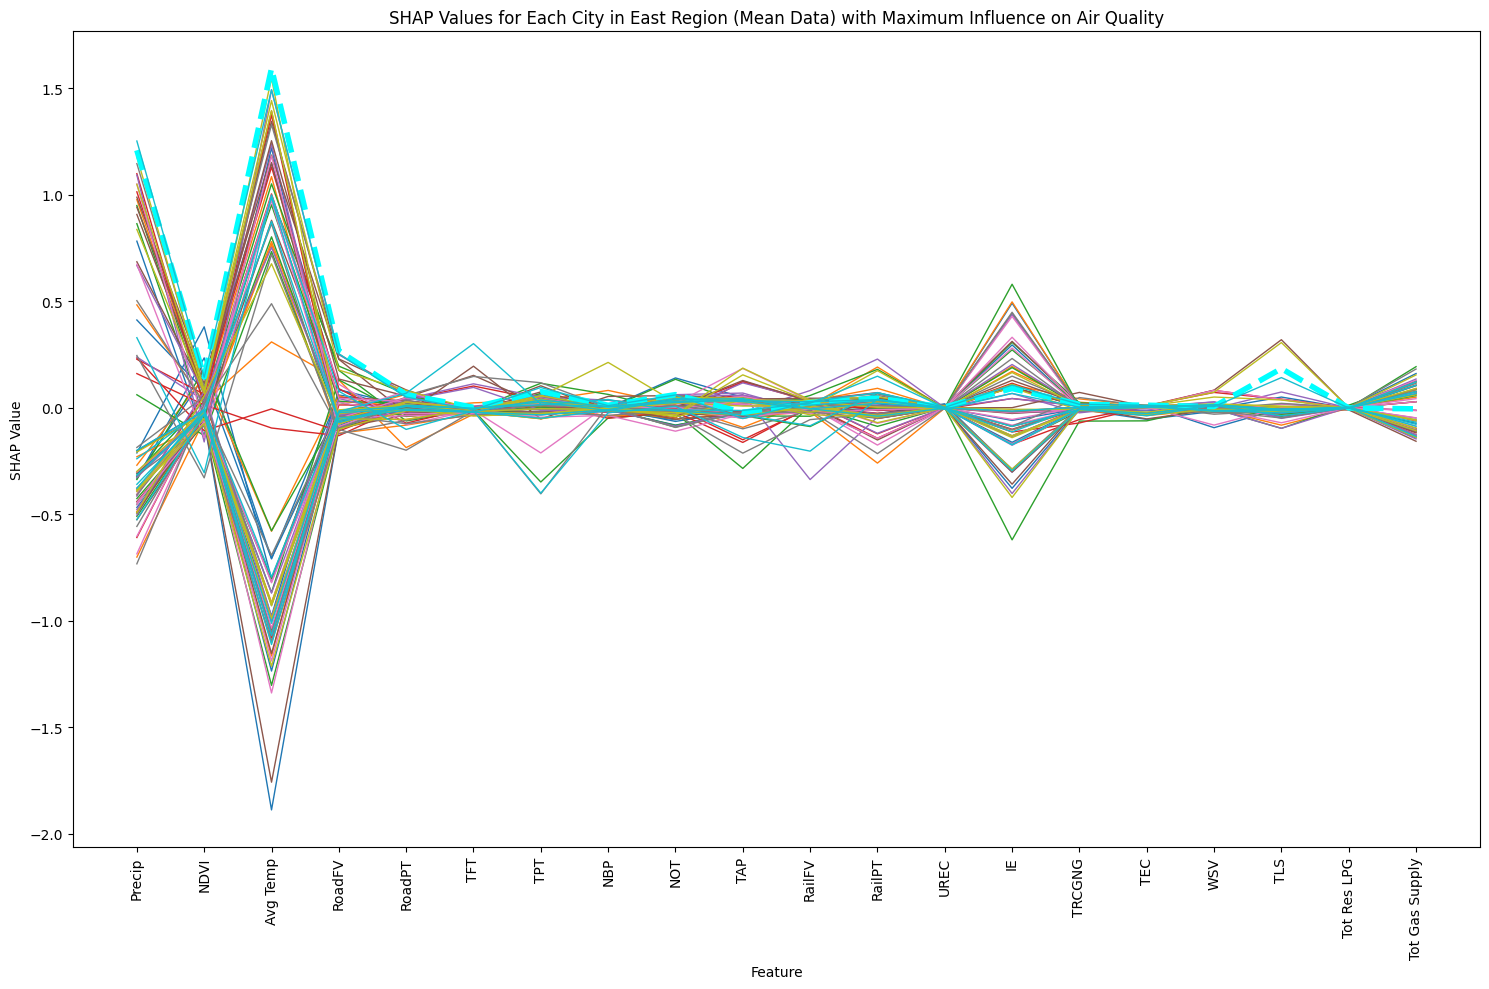

In [2]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 读取 Excel 文件
yaqem_df = pd.read_excel("YAQEM.xlsx")
xne_df = pd.read_excel("XNE.xlsx")
xtn_df = pd.read_excel("XTN.xlsx")
xec_df = pd.read_excel("XEC.xlsx")

# 选择空气质量相关特征进行 PCA 降维
air_quality_features = ["CO", "NO2", "O3", "PM2_5", "PM10", "SO2"]
yaqem_filtered = yaqem_df[air_quality_features].dropna()

scaler = StandardScaler()
yaqem_scaled = scaler.fit_transform(yaqem_filtered)

pca = PCA(n_components=1)
yaqem_pca = pca.fit_transform(yaqem_scaled)

yaqem_df["AirQualityIndex"] = yaqem_pca

# 确保 `year` 列唯一，删除重复列
xne_df = xne_df.loc[:, ~xne_df.columns.duplicated()]
xtn_df = xtn_df.loc[:, ~xtn_df.columns.duplicated()]
xec_df = xec_df.loc[:, ~xec_df.columns.duplicated()]
yaqem_df = yaqem_df.loc[:, ~yaqem_df.columns.duplicated()]

# 直接指定 20 个数据特征列名，并修正 RFV -> RoadFV, RPT -> RoadPT
feature_columns = [
    "Precip", "NDVI", "Avg Temp",  # 自然环境 (XNE)
    "RoadFV", "RoadPT", "TFT", "TPT", "NBP", "NOT", "TAP", "RailFV", "RailPT",  # 交通 (XTN)
    "UREC", "IE", "TRCGNG", "TEC", "WSV", "TLS", "Tot Res LPG", "Tot Gas Supply"  # 能源 (XEC)
]

# 合并 X 数据（自然环境、交通、能源）
x_data = xne_df.merge(xtn_df, on=["city", "year"], how="outer")
x_data = x_data.merge(xec_df, on=["city", "year"], how="outer")

# 确保 `year` 只出现一次
x_data = x_data.loc[:, ~x_data.columns.duplicated()]

# 仅保留指定的 20 个特征
x_data = x_data[["city", "year"] + feature_columns]

# 合并 X 和 Y 数据（使用 left join 确保数据不丢失）
final_data = yaqem_df[["city", "year", "AirQualityIndex", "quyu"]].merge(x_data, on=["city", "year"], how="left")

# 使用 fillna(0) 填充缺失值，确保 X 数据完整
final_data_cleaned = final_data.fillna(0)

# 选择特征和目标变量
X = final_data_cleaned[feature_columns]
Y = final_data_cleaned["AirQualityIndex"]

# 处理非数值列
X = X.select_dtypes(include=[np.number])

# 强制转换所有特征列为数值类型
for col in feature_columns:
    final_data_cleaned[col] = pd.to_numeric(final_data_cleaned[col], errors="coerce")

# 获取东部区域的城市数据
east_region_data = final_data_cleaned[final_data_cleaned["quyu"] == "东部"]

# 按城市计算均值（包括 `AirQualityIndex`）
east_region_avg = east_region_data.groupby("city")[feature_columns + ['AirQualityIndex']].mean()

# 获取东部区域城市的列表
east_region_cities = east_region_avg.index.tolist()

# 获取 SHAP 值
X_filled = east_region_avg[feature_columns].fillna(0)
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X_filled, east_region_avg["AirQualityIndex"])

# 计算 SHAP 值
explainer = shap.Explainer(model, X_filled)
shap_values = explainer(X_filled)

# 绘制 SHAP 值折线图
plt.figure(figsize=(15, 10))

# 定义颜色映射
city_colors = plt.cm.get_cmap("tab10", len(east_region_cities))

# 找到正向影响最大的城市
max_shap_value = -np.inf
max_shap_city = None

# 获取每个城市的最大正向 SHAP 值并选出影响最大的城市
city_max_shap_values = {}

for i, city in enumerate(east_region_cities):
    # 获取该城市的 SHAP 值
    city_shap_values = shap_values.values[i]  # 使用索引 i 获取 SHAP 值
    
    # 确保 city_shap_values 是一个包含 20 个特征的数组
    if city_shap_values.ndim == 1 and len(city_shap_values) == len(feature_columns):
        avg_shap_values = city_shap_values  # SHAP 值本身已经是一个 20 维的数组
    else:
        print(f"警告: {city} 的 SHAP 值维度不匹配，跳过该城市。")
        continue
    
    # 计算每个城市的最大正向 SHAP 值
    city_max_shap_values[city] = np.max(avg_shap_values)

# 按最大 SHAP 值排序，找到最大正向影响的城市
max_shap_city = max(city_max_shap_values, key=city_max_shap_values.get)

# 绘制各个城市的折线
for i, city in enumerate(east_region_cities):
    # 获取该城市的 SHAP 值
    city_shap_values = shap_values.values[i]  # 使用索引 i 获取 SHAP 值
    
    # 确保 city_shap_values 是一个包含 20 个特征的数组
    if city_shap_values.ndim == 1 and len(city_shap_values) == len(feature_columns):
        avg_shap_values = city_shap_values  # SHAP 值本身已经是一个 20 维的数组
    else:
        continue
    
    # 影响最大的城市使用虚线并加粗，颜色为荧光青色
    linestyle = '--' if city == max_shap_city else '-'
    linewidth = 4 if city == max_shap_city else 1  # 加粗影响最大城市的虚线
    color = 'cyan' if city == max_shap_city else city_colors(i)  # 设置最大影响城市的颜色为荧光色
    
    plt.plot(feature_columns, avg_shap_values, color=color, linestyle=linestyle, linewidth=linewidth)

# 设置标题和标签
plt.title("SHAP Values for Each City in East Region (Mean Data) with Maximum Influence on Air Quality")
plt.xlabel("Feature")
plt.ylabel("SHAP Value")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


# 东北

C:\Users\huawei\AppData\Local\Temp\ipykernel_22888\1961375903.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  city_colors = plt.cm.get_cmap("tab10", len(east_region_cities))


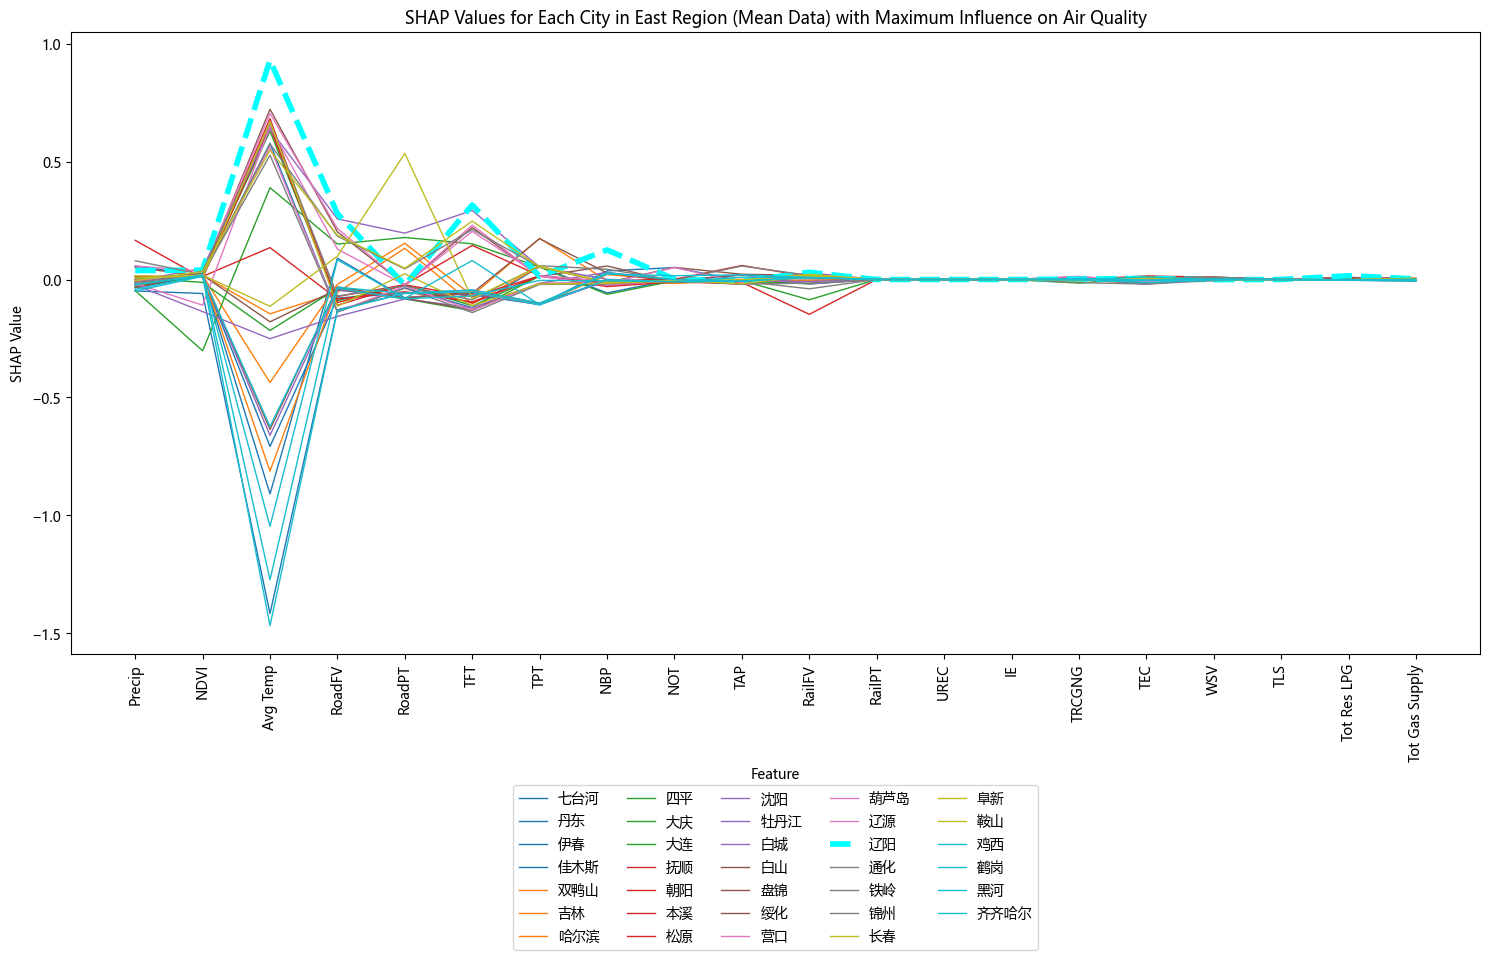

In [48]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 读取 Excel 文件
yaqem_df = pd.read_excel("YAQEM.xlsx")
xne_df = pd.read_excel("XNE.xlsx")
xtn_df = pd.read_excel("XTN.xlsx")
xec_df = pd.read_excel("XEC.xlsx")

# 选择空气质量相关特征进行 PCA 降维
air_quality_features = ["CO", "NO2", "O3", "PM2_5", "PM10", "SO2"]
yaqem_filtered = yaqem_df[air_quality_features].dropna()

scaler = StandardScaler()
yaqem_scaled = scaler.fit_transform(yaqem_filtered)

pca = PCA(n_components=1)
yaqem_pca = pca.fit_transform(yaqem_scaled)

yaqem_df["AirQualityIndex"] = yaqem_pca

# 确保 `year` 列唯一，删除重复列
xne_df = xne_df.loc[:, ~xne_df.columns.duplicated()]
xtn_df = xtn_df.loc[:, ~xtn_df.columns.duplicated()]
xec_df = xec_df.loc[:, ~xec_df.columns.duplicated()]
yaqem_df = yaqem_df.loc[:, ~yaqem_df.columns.duplicated()]

# 直接指定 20 个数据特征列名，并修正 RFV -> RoadFV, RPT -> RoadPT
feature_columns = [
    "Precip", "NDVI", "Avg Temp",  # 自然环境 (XNE)
    "RoadFV", "RoadPT", "TFT", "TPT", "NBP", "NOT", "TAP", "RailFV", "RailPT",  # 交通 (XTN)
    "UREC", "IE", "TRCGNG", "TEC", "WSV", "TLS", "Tot Res LPG", "Tot Gas Supply"  # 能源 (XEC)
]

# 合并 X 数据（自然环境、交通、能源）
x_data = xne_df.merge(xtn_df, on=["city", "year"], how="outer")
x_data = x_data.merge(xec_df, on=["city", "year"], how="outer")

# 确保 `year` 只出现一次
x_data = x_data.loc[:, ~x_data.columns.duplicated()]

# 仅保留指定的 20 个特征
x_data = x_data[["city", "year"] + feature_columns]

# 合并 X 和 Y 数据（使用 left join 确保数据不丢失）
final_data = yaqem_df[["city", "year", "AirQualityIndex", "quyu"]].merge(x_data, on=["city", "year"], how="left")

# 使用 fillna(0) 填充缺失值，确保 X 数据完整
final_data_cleaned = final_data.fillna(0)

# 选择特征和目标变量
X = final_data_cleaned[feature_columns]
Y = final_data_cleaned["AirQualityIndex"]

# 处理非数值列
X = X.select_dtypes(include=[np.number])

# 强制转换所有特征列为数值类型
for col in feature_columns:
    final_data_cleaned[col] = pd.to_numeric(final_data_cleaned[col], errors="coerce")

# 获取东部区域的城市数据
east_region_data = final_data_cleaned[final_data_cleaned["quyu"] == "东北"]

# 按城市计算均值（包括 `AirQualityIndex`）
east_region_avg = east_region_data.groupby("city")[feature_columns + ['AirQualityIndex']].mean()

# 获取东部区域城市的列表
east_region_cities = east_region_avg.index.tolist()

# 获取 SHAP 值
X_filled = east_region_avg[feature_columns].fillna(0)
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X_filled, east_region_avg["AirQualityIndex"])

# 计算 SHAP 值
explainer = shap.Explainer(model, X_filled)
shap_values = explainer(X_filled)

# 绘制 SHAP 值折线图
plt.figure(figsize=(15, 10))

# 定义颜色映射
city_colors = plt.cm.get_cmap("tab10", len(east_region_cities))

# 找到正向影响最大的城市
max_shap_value = -np.inf
max_shap_city = None

# 获取每个城市的最大正向 SHAP 值并选出影响最大的城市
city_max_shap_values = {}

for i, city in enumerate(east_region_cities):
    # 获取该城市的 SHAP 值
    city_shap_values = shap_values.values[i]  # 使用索引 i 获取 SHAP 值
    
    # 确保 city_shap_values 是一个包含 20 个特征的数组
    if city_shap_values.ndim == 1 and len(city_shap_values) == len(feature_columns):
        avg_shap_values = city_shap_values  # SHAP 值本身已经是一个 20 维的数组
    else:
        print(f"警告: {city} 的 SHAP 值维度不匹配，跳过该城市。")
        continue
    
    # 计算每个城市的最大正向 SHAP 值
    city_max_shap_values[city] = np.max(avg_shap_values)

# 按最大 SHAP 值排序，找到最大正向影响的城市
max_shap_city = max(city_max_shap_values, key=city_max_shap_values.get)

# 绘制各个城市的折线
for i, city in enumerate(east_region_cities):
    # 获取该城市的 SHAP 值
    city_shap_values = shap_values.values[i]  # 使用索引 i 获取 SHAP 值
    
    # 确保 city_shap_values 是一个包含 20 个特征的数组
    if city_shap_values.ndim == 1 and len(city_shap_values) == len(feature_columns):
        avg_shap_values = city_shap_values  # SHAP 值本身已经是一个 20 维的数组
    else:
        continue
    
    # 影响最大的城市使用虚线并加粗，颜色为荧光青色
    linestyle = '--' if city == max_shap_city else '-'
    linewidth = 4 if city == max_shap_city else 1  # 加粗影响最大城市的虚线
    color = 'cyan' if city == max_shap_city else city_colors(i)  # 设置最大影响城市的颜色为荧光色
    
    plt.plot(feature_columns, avg_shap_values, label=city, color=color, linestyle=linestyle, linewidth=linewidth)

# 设置标题和标签
plt.title("SHAP Values for Each City in East Region (Mean Data) with Maximum Influence on Air Quality")
plt.xlabel("Feature")
plt.ylabel("SHAP Value")
plt.xticks(rotation=90)

# 设置图例位置在横轴下方，避免遮挡
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=5)  # 设置图例在图形下方

plt.tight_layout()
plt.show()


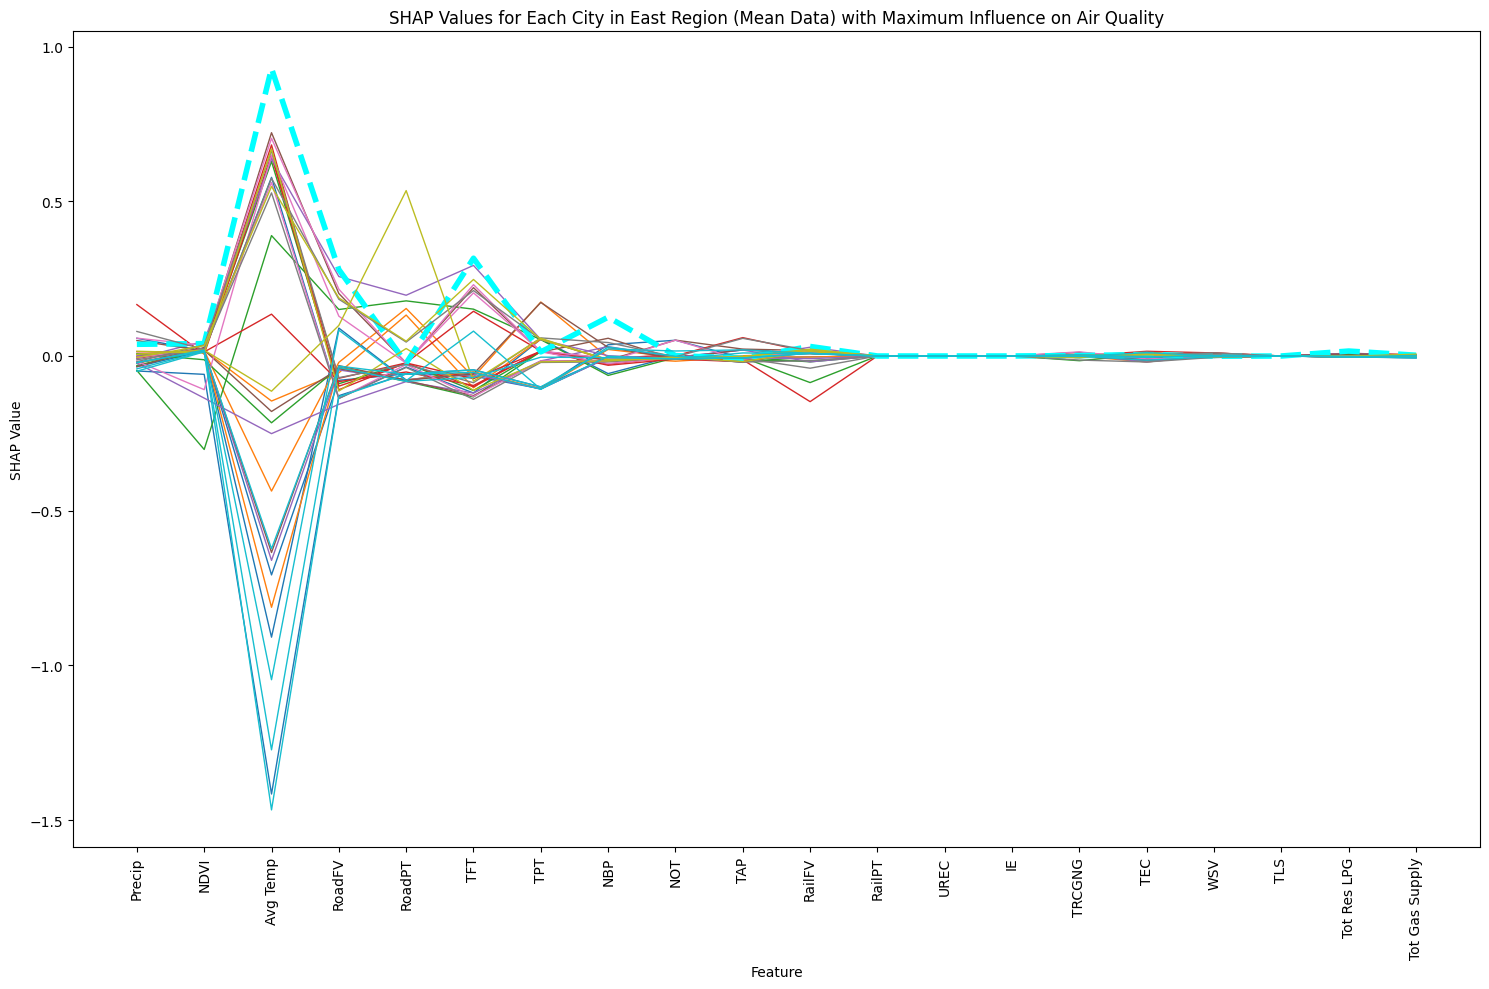

In [3]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 读取 Excel 文件
yaqem_df = pd.read_excel("YAQEM.xlsx")
xne_df = pd.read_excel("XNE.xlsx")
xtn_df = pd.read_excel("XTN.xlsx")
xec_df = pd.read_excel("XEC.xlsx")

# 选择空气质量相关特征进行 PCA 降维
air_quality_features = ["CO", "NO2", "O3", "PM2_5", "PM10", "SO2"]
yaqem_filtered = yaqem_df[air_quality_features].dropna()

scaler = StandardScaler()
yaqem_scaled = scaler.fit_transform(yaqem_filtered)

pca = PCA(n_components=1)
yaqem_pca = pca.fit_transform(yaqem_scaled)

yaqem_df["AirQualityIndex"] = yaqem_pca

# 确保 `year` 列唯一，删除重复列
xne_df = xne_df.loc[:, ~xne_df.columns.duplicated()]
xtn_df = xtn_df.loc[:, ~xtn_df.columns.duplicated()]
xec_df = xec_df.loc[:, ~xec_df.columns.duplicated()]
yaqem_df = yaqem_df.loc[:, ~yaqem_df.columns.duplicated()]

# 直接指定 20 个数据特征列名，并修正 RFV -> RoadFV, RPT -> RoadPT
feature_columns = [
    "Precip", "NDVI", "Avg Temp",  # 自然环境 (XNE)
    "RoadFV", "RoadPT", "TFT", "TPT", "NBP", "NOT", "TAP", "RailFV", "RailPT",  # 交通 (XTN)
    "UREC", "IE", "TRCGNG", "TEC", "WSV", "TLS", "Tot Res LPG", "Tot Gas Supply"  # 能源 (XEC)
]

# 合并 X 数据（自然环境、交通、能源）
x_data = xne_df.merge(xtn_df, on=["city", "year"], how="outer")
x_data = x_data.merge(xec_df, on=["city", "year"], how="outer")

# 确保 `year` 只出现一次
x_data = x_data.loc[:, ~x_data.columns.duplicated()]

# 仅保留指定的 20 个特征
x_data = x_data[["city", "year"] + feature_columns]

# 合并 X 和 Y 数据（使用 left join 确保数据不丢失）
final_data = yaqem_df[["city", "year", "AirQualityIndex", "quyu"]].merge(x_data, on=["city", "year"], how="left")

# 使用 fillna(0) 填充缺失值，确保 X 数据完整
final_data_cleaned = final_data.fillna(0)

# 选择特征和目标变量
X = final_data_cleaned[feature_columns]
Y = final_data_cleaned["AirQualityIndex"]

# 处理非数值列
X = X.select_dtypes(include=[np.number])

# 强制转换所有特征列为数值类型
for col in feature_columns:
    final_data_cleaned[col] = pd.to_numeric(final_data_cleaned[col], errors="coerce")

# 获取东部区域的城市数据
east_region_data = final_data_cleaned[final_data_cleaned["quyu"] == "东北"]

# 按城市计算均值（包括 `AirQualityIndex`）
east_region_avg = east_region_data.groupby("city")[feature_columns + ['AirQualityIndex']].mean()

# 获取东部区域城市的列表
east_region_cities = east_region_avg.index.tolist()

# 获取 SHAP 值
X_filled = east_region_avg[feature_columns].fillna(0)
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X_filled, east_region_avg["AirQualityIndex"])

# 计算 SHAP 值
explainer = shap.Explainer(model, X_filled)
shap_values = explainer(X_filled)

# 绘制 SHAP 值折线图
plt.figure(figsize=(15, 10))

# 定义颜色映射
city_colors = plt.get_cmap("tab10", len(east_region_cities))

# 找到正向影响最大的城市
max_shap_value = -np.inf
max_shap_city = None

# 获取每个城市的最大正向 SHAP 值并选出影响最大的城市
city_max_shap_values = {}

for i, city in enumerate(east_region_cities):
    # 获取该城市的 SHAP 值
    city_shap_values = shap_values.values[i]  # 使用索引 i 获取 SHAP 值
    
    # 确保 city_shap_values 是一个包含 20 个特征的数组
    if city_shap_values.ndim == 1 and len(city_shap_values) == len(feature_columns):
        avg_shap_values = city_shap_values  # SHAP 值本身已经是一个 20 维的数组
    else:
        print(f"警告: {city} 的 SHAP 值维度不匹配，跳过该城市。")
        continue
    
    # 计算每个城市的最大正向 SHAP 值
    city_max_shap_values[city] = np.max(avg_shap_values)

# 按最大 SHAP 值排序，找到最大正向影响的城市
max_shap_city = max(city_max_shap_values, key=city_max_shap_values.get)

# 绘制各个城市的折线
for i, city in enumerate(east_region_cities):
    # 获取该城市的 SHAP 值
    city_shap_values = shap_values.values[i]  # 使用索引 i 获取 SHAP 值
    
    # 确保 city_shap_values 是一个包含 20 个特征的数组
    if city_shap_values.ndim == 1 and len(city_shap_values) == len(feature_columns):
        avg_shap_values = city_shap_values  # SHAP 值本身已经是一个 20 维的数组
    else:
        continue
    
    # 影响最大的城市使用虚线并加粗，颜色为荧光青色
    linestyle = '--' if city == max_shap_city else '-'
    linewidth = 4 if city == max_shap_city else 1  # 加粗影响最大城市的虚线
    color = 'cyan' if city == max_shap_city else city_colors(i)  # 设置最大影响城市的颜色为荧光色
    
    plt.plot(feature_columns, avg_shap_values, color=color, linestyle=linestyle, linewidth=linewidth)

# 设置标题和标签
plt.title("SHAP Values for Each City in East Region (Mean Data) with Maximum Influence on Air Quality")
plt.xlabel("Feature")
plt.ylabel("SHAP Value")
plt.xticks(rotation=90)

# 图例已被移除

plt.tight_layout()
plt.show()


# 中部

C:\Users\huawei\AppData\Local\Temp\ipykernel_22888\1164975585.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  city_colors = plt.cm.get_cmap("tab10", len(east_region_cities))


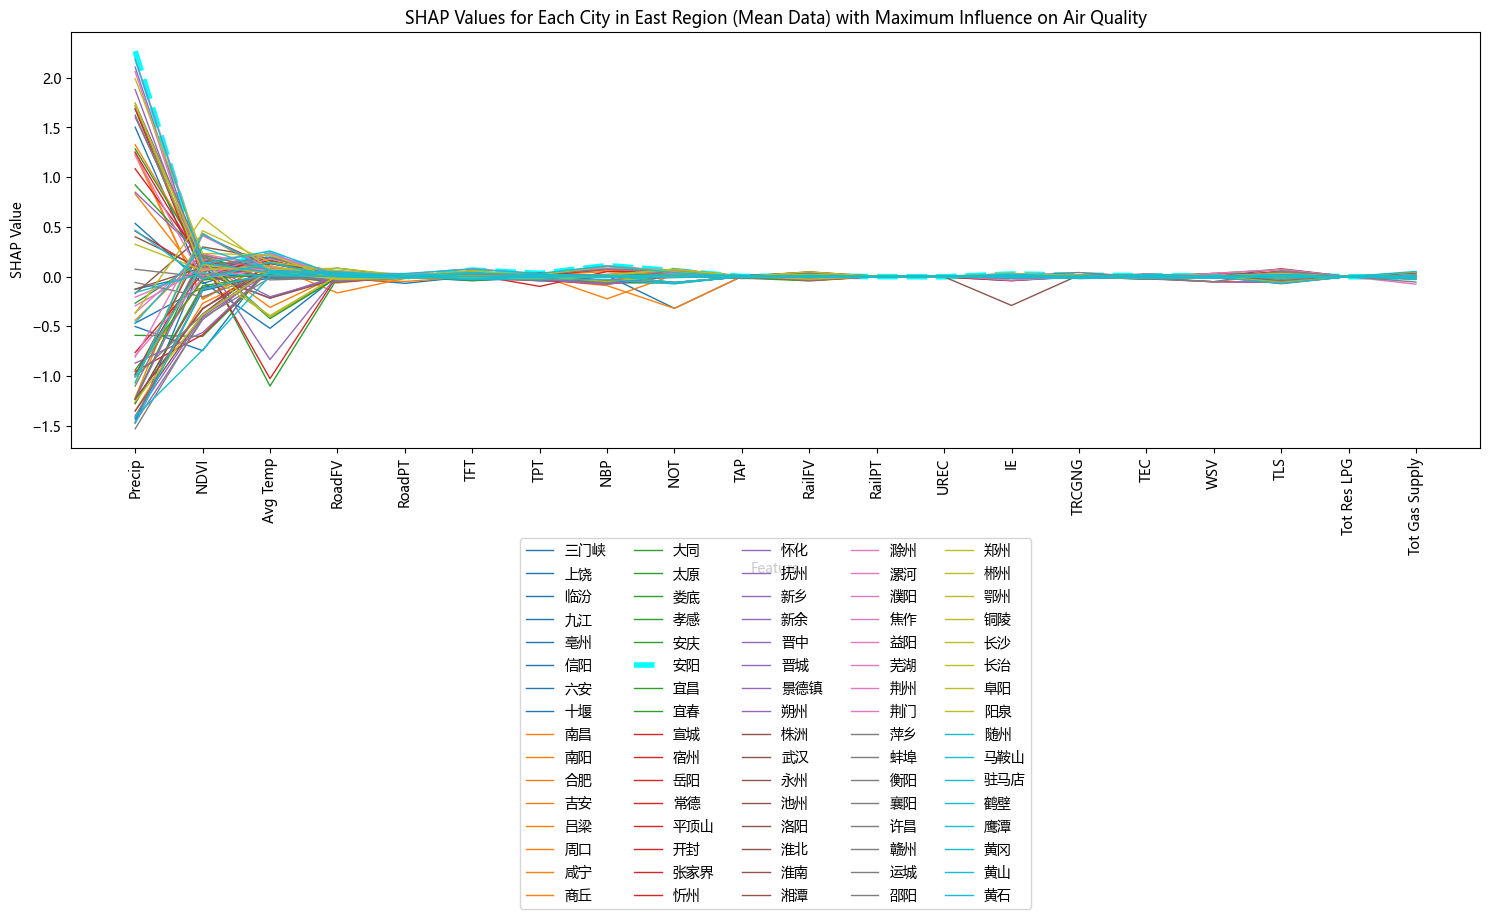

In [53]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 读取 Excel 文件
yaqem_df = pd.read_excel("YAQEM.xlsx")
xne_df = pd.read_excel("XNE.xlsx")
xtn_df = pd.read_excel("XTN.xlsx")
xec_df = pd.read_excel("XEC.xlsx")

# 选择空气质量相关特征进行 PCA 降维
air_quality_features = ["CO", "NO2", "O3", "PM2_5", "PM10", "SO2"]
yaqem_filtered = yaqem_df[air_quality_features].dropna()

scaler = StandardScaler()
yaqem_scaled = scaler.fit_transform(yaqem_filtered)

pca = PCA(n_components=1)
yaqem_pca = pca.fit_transform(yaqem_scaled)

yaqem_df["AirQualityIndex"] = yaqem_pca

# 确保 `year` 列唯一，删除重复列
xne_df = xne_df.loc[:, ~xne_df.columns.duplicated()]
xtn_df = xtn_df.loc[:, ~xtn_df.columns.duplicated()]
xec_df = xec_df.loc[:, ~xec_df.columns.duplicated()]
yaqem_df = yaqem_df.loc[:, ~yaqem_df.columns.duplicated()]

# 直接指定 20 个数据特征列名，并修正 RFV -> RoadFV, RPT -> RoadPT
feature_columns = [
    "Precip", "NDVI", "Avg Temp",  # 自然环境 (XNE)
    "RoadFV", "RoadPT", "TFT", "TPT", "NBP", "NOT", "TAP", "RailFV", "RailPT",  # 交通 (XTN)
    "UREC", "IE", "TRCGNG", "TEC", "WSV", "TLS", "Tot Res LPG", "Tot Gas Supply"  # 能源 (XEC)
]

# 合并 X 数据（自然环境、交通、能源）
x_data = xne_df.merge(xtn_df, on=["city", "year"], how="outer")
x_data = x_data.merge(xec_df, on=["city", "year"], how="outer")

# 确保 `year` 只出现一次
x_data = x_data.loc[:, ~x_data.columns.duplicated()]

# 仅保留指定的 20 个特征
x_data = x_data[["city", "year"] + feature_columns]

# 合并 X 和 Y 数据（使用 left join 确保数据不丢失）
final_data = yaqem_df[["city", "year", "AirQualityIndex", "quyu"]].merge(x_data, on=["city", "year"], how="left")

# 使用 fillna(0) 填充缺失值，确保 X 数据完整
final_data_cleaned = final_data.fillna(0)

# 选择特征和目标变量
X = final_data_cleaned[feature_columns]
Y = final_data_cleaned["AirQualityIndex"]

# 处理非数值列
X = X.select_dtypes(include=[np.number])

# 强制转换所有特征列为数值类型
for col in feature_columns:
    final_data_cleaned[col] = pd.to_numeric(final_data_cleaned[col], errors="coerce")

# 获取东部区域的城市数据
east_region_data = final_data_cleaned[final_data_cleaned["quyu"] == "中部"]

# 按城市计算均值（包括 `AirQualityIndex`）
east_region_avg = east_region_data.groupby("city")[feature_columns + ['AirQualityIndex']].mean()

# 获取东部区域城市的列表
east_region_cities = east_region_avg.index.tolist()

# 获取 SHAP 值
X_filled = east_region_avg[feature_columns].fillna(0)
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X_filled, east_region_avg["AirQualityIndex"])

# 计算 SHAP 值
explainer = shap.Explainer(model, X_filled)
shap_values = explainer(X_filled)

# 绘制 SHAP 值折线图
plt.figure(figsize=(15, 10))

# 定义颜色映射
city_colors = plt.cm.get_cmap("tab10", len(east_region_cities))

# 找到正向影响最大的城市
max_shap_value = -np.inf
max_shap_city = None

# 获取每个城市的最大正向 SHAP 值并选出影响最大的城市
city_max_shap_values = {}

for i, city in enumerate(east_region_cities):
    # 获取该城市的 SHAP 值
    city_shap_values = shap_values.values[i]  # 使用索引 i 获取 SHAP 值
    
    # 确保 city_shap_values 是一个包含 20 个特征的数组
    if city_shap_values.ndim == 1 and len(city_shap_values) == len(feature_columns):
        avg_shap_values = city_shap_values  # SHAP 值本身已经是一个 20 维的数组
    else:
        print(f"警告: {city} 的 SHAP 值维度不匹配，跳过该城市。")
        continue
    
    # 计算每个城市的最大正向 SHAP 值
    city_max_shap_values[city] = np.max(avg_shap_values)

# 按最大 SHAP 值排序，找到最大正向影响的城市
max_shap_city = max(city_max_shap_values, key=city_max_shap_values.get)

# 绘制各个城市的折线
for i, city in enumerate(east_region_cities):
    # 获取该城市的 SHAP 值
    city_shap_values = shap_values.values[i]  # 使用索引 i 获取 SHAP 值
    
    # 确保 city_shap_values 是一个包含 20 个特征的数组
    if city_shap_values.ndim == 1 and len(city_shap_values) == len(feature_columns):
        avg_shap_values = city_shap_values  # SHAP 值本身已经是一个 20 维的数组
    else:
        continue
    
    # 影响最大的城市使用虚线并加粗，颜色为荧光青色
    linestyle = '--' if city == max_shap_city else '-'
    linewidth = 4 if city == max_shap_city else 1  # 加粗影响最大城市的虚线
    color = 'cyan' if city == max_shap_city else city_colors(i)  # 设置最大影响城市的颜色为荧光色
    
    plt.plot(feature_columns, avg_shap_values, label=city, color=color, linestyle=linestyle, linewidth=linewidth)

# 设置标题和标签
plt.title("SHAP Values for Each City in East Region (Mean Data) with Maximum Influence on Air Quality")
plt.xlabel("Feature")
plt.ylabel("SHAP Value")
plt.xticks(rotation=90)

# 设置图例位置在横轴下方，避免遮挡
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=5)  # 设置图例在图形下方

plt.tight_layout()
plt.show()


C:\Users\huawei\AppData\Local\Temp\ipykernel_1396\1519805900.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  city_colors = plt.cm.get_cmap("tab10", len(east_region_cities))


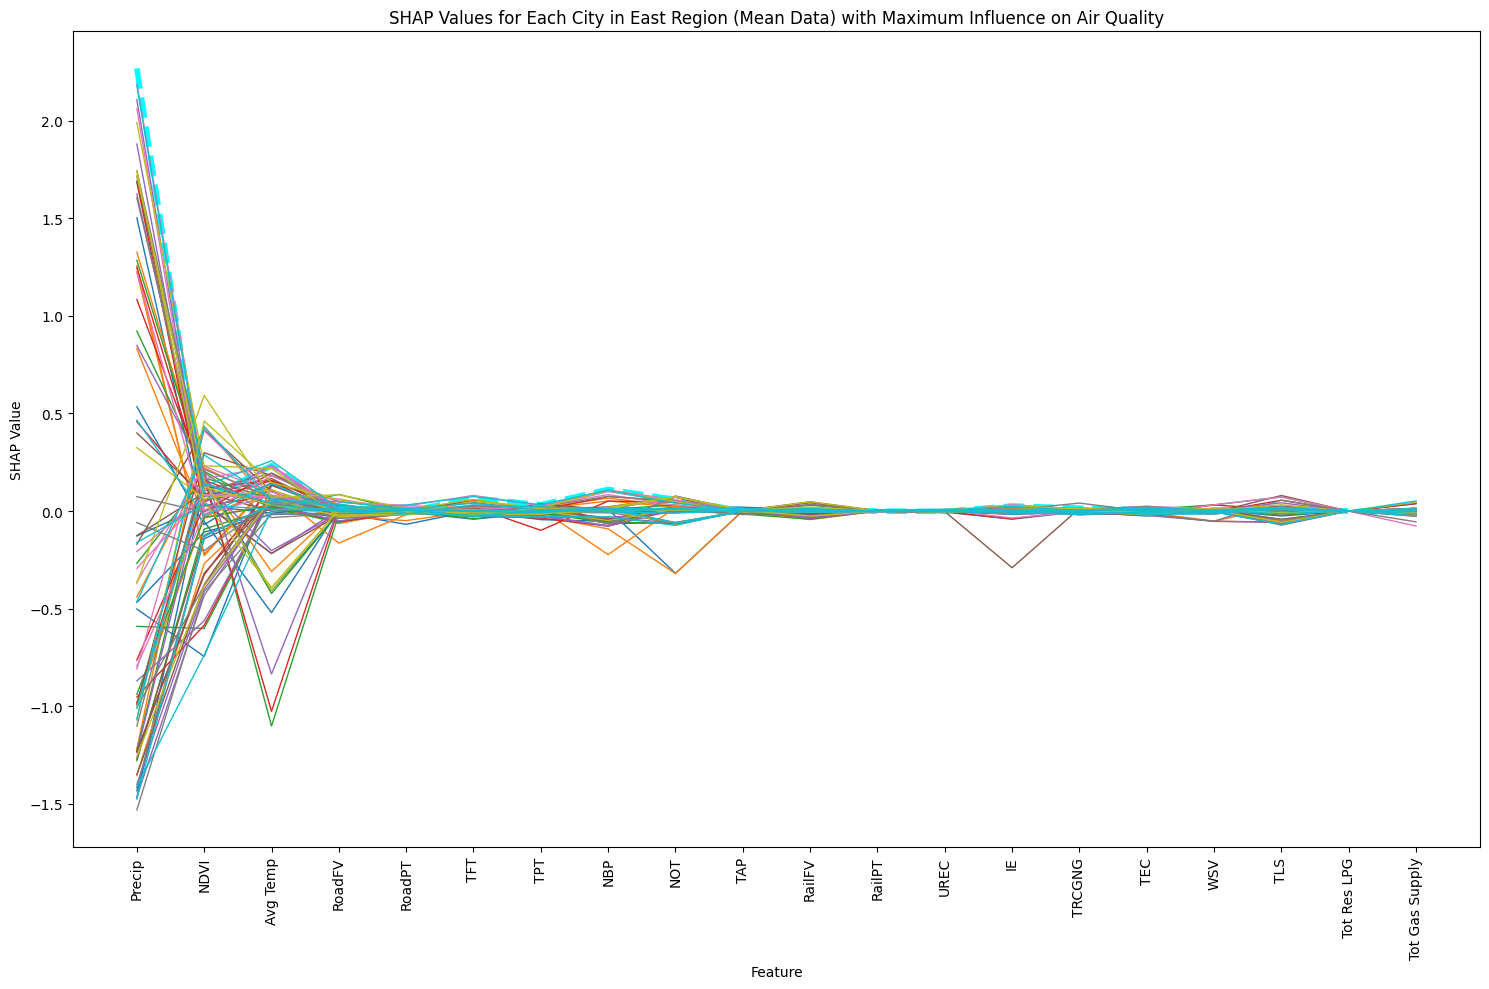

In [4]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 读取 Excel 文件
yaqem_df = pd.read_excel("YAQEM.xlsx")
xne_df = pd.read_excel("XNE.xlsx")
xtn_df = pd.read_excel("XTN.xlsx")
xec_df = pd.read_excel("XEC.xlsx")

# 选择空气质量相关特征进行 PCA 降维
air_quality_features = ["CO", "NO2", "O3", "PM2_5", "PM10", "SO2"]
yaqem_filtered = yaqem_df[air_quality_features].dropna()

scaler = StandardScaler()
yaqem_scaled = scaler.fit_transform(yaqem_filtered)

pca = PCA(n_components=1)
yaqem_pca = pca.fit_transform(yaqem_scaled)

yaqem_df["AirQualityIndex"] = yaqem_pca

# 确保 `year` 列唯一，删除重复列
xne_df = xne_df.loc[:, ~xne_df.columns.duplicated()]
xtn_df = xtn_df.loc[:, ~xtn_df.columns.duplicated()]
xec_df = xec_df.loc[:, ~xec_df.columns.duplicated()]
yaqem_df = yaqem_df.loc[:, ~yaqem_df.columns.duplicated()]

# 直接指定 20 个数据特征列名，并修正 RFV -> RoadFV, RPT -> RoadPT
feature_columns = [
    "Precip", "NDVI", "Avg Temp",  # 自然环境 (XNE)
    "RoadFV", "RoadPT", "TFT", "TPT", "NBP", "NOT", "TAP", "RailFV", "RailPT",  # 交通 (XTN)
    "UREC", "IE", "TRCGNG", "TEC", "WSV", "TLS", "Tot Res LPG", "Tot Gas Supply"  # 能源 (XEC)
]

# 合并 X 数据（自然环境、交通、能源）
x_data = xne_df.merge(xtn_df, on=["city", "year"], how="outer")
x_data = x_data.merge(xec_df, on=["city", "year"], how="outer")

# 确保 `year` 只出现一次
x_data = x_data.loc[:, ~x_data.columns.duplicated()]

# 仅保留指定的 20 个特征
x_data = x_data[["city", "year"] + feature_columns]

# 合并 X 和 Y 数据（使用 left join 确保数据不丢失）
final_data = yaqem_df[["city", "year", "AirQualityIndex", "quyu"]].merge(x_data, on=["city", "year"], how="left")

# 使用 fillna(0) 填充缺失值，确保 X 数据完整
final_data_cleaned = final_data.fillna(0)

# 选择特征和目标变量
X = final_data_cleaned[feature_columns]
Y = final_data_cleaned["AirQualityIndex"]

# 处理非数值列
X = X.select_dtypes(include=[np.number])

# 强制转换所有特征列为数值类型
for col in feature_columns:
    final_data_cleaned[col] = pd.to_numeric(final_data_cleaned[col], errors="coerce")

# 获取东部区域的城市数据
east_region_data = final_data_cleaned[final_data_cleaned["quyu"] == "中部"]

# 按城市计算均值（包括 `AirQualityIndex`）
east_region_avg = east_region_data.groupby("city")[feature_columns + ['AirQualityIndex']].mean()

# 获取东部区域城市的列表
east_region_cities = east_region_avg.index.tolist()

# 获取 SHAP 值
X_filled = east_region_avg[feature_columns].fillna(0)
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X_filled, east_region_avg["AirQualityIndex"])

# 计算 SHAP 值
explainer = shap.Explainer(model, X_filled)
shap_values = explainer(X_filled)

# 绘制 SHAP 值折线图
plt.figure(figsize=(15, 10))

# 定义颜色映射
city_colors = plt.cm.get_cmap("tab10", len(east_region_cities))

# 找到正向影响最大的城市
max_shap_value = -np.inf
max_shap_city = None

# 获取每个城市的最大正向 SHAP 值并选出影响最大的城市
city_max_shap_values = {}

for i, city in enumerate(east_region_cities):
    # 获取该城市的 SHAP 值
    city_shap_values = shap_values.values[i]  # 使用索引 i 获取 SHAP 值
    
    # 确保 city_shap_values 是一个包含 20 个特征的数组
    if city_shap_values.ndim == 1 and len(city_shap_values) == len(feature_columns):
        avg_shap_values = city_shap_values  # SHAP 值本身已经是一个 20 维的数组
    else:
        print(f"警告: {city} 的 SHAP 值维度不匹配，跳过该城市。")
        continue
    
    # 计算每个城市的最大正向 SHAP 值
    city_max_shap_values[city] = np.max(avg_shap_values)

# 按最大 SHAP 值排序，找到最大正向影响的城市
max_shap_city = max(city_max_shap_values, key=city_max_shap_values.get)

# 绘制各个城市的折线
for i, city in enumerate(east_region_cities):
    # 获取该城市的 SHAP 值
    city_shap_values = shap_values.values[i]  # 使用索引 i 获取 SHAP 值
    
    # 确保 city_shap_values 是一个包含 20 个特征的数组
    if city_shap_values.ndim == 1 and len(city_shap_values) == len(feature_columns):
        avg_shap_values = city_shap_values  # SHAP 值本身已经是一个 20 维的数组
    else:
        continue
    
    # 影响最大的城市使用虚线并加粗，颜色为荧光青色
    linestyle = '--' if city == max_shap_city else '-'
    linewidth = 4 if city == max_shap_city else 1  # 加粗影响最大城市的虚线
    color = 'cyan' if city == max_shap_city else city_colors(i)  # 设置最大影响城市的颜色为荧光色
    
    plt.plot(feature_columns, avg_shap_values, color=color, linestyle=linestyle, linewidth=linewidth)

# 设置标题和标签
plt.title("SHAP Values for Each City in East Region (Mean Data) with Maximum Influence on Air Quality")
plt.xlabel("Feature")
plt.ylabel("SHAP Value")
plt.xticks(rotation=90)

# 图例已被移除

plt.tight_layout()
plt.show()


# 西部

C:\Users\huawei\AppData\Local\Temp\ipykernel_22888\3082510940.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  city_colors = plt.cm.get_cmap("tab10", len(east_region_cities))


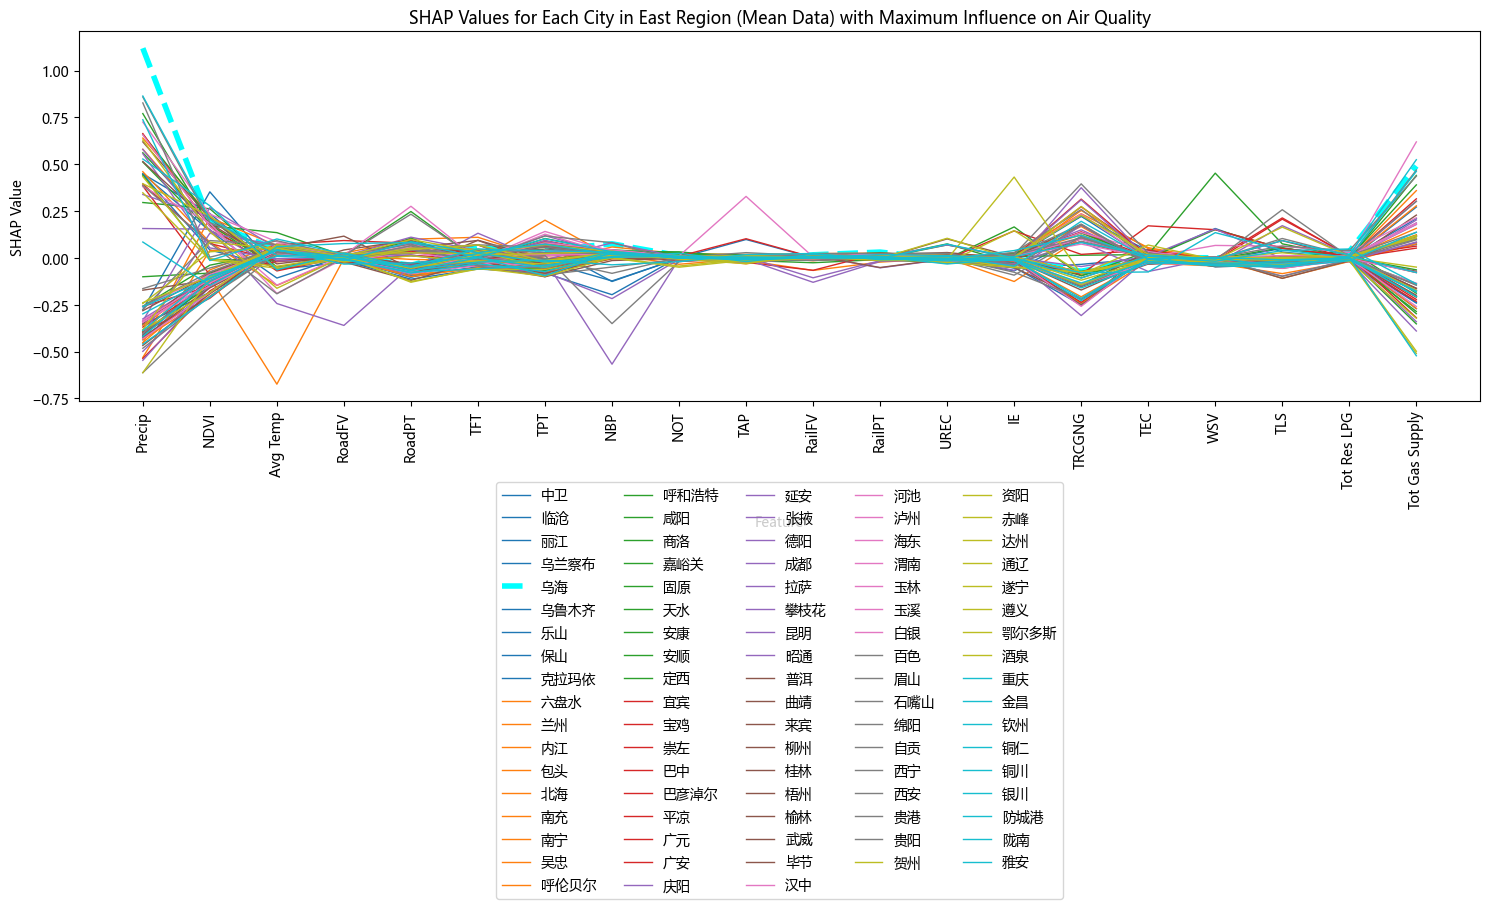

In [54]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 读取 Excel 文件
yaqem_df = pd.read_excel("YAQEM.xlsx")
xne_df = pd.read_excel("XNE.xlsx")
xtn_df = pd.read_excel("XTN.xlsx")
xec_df = pd.read_excel("XEC.xlsx")

# 选择空气质量相关特征进行 PCA 降维
air_quality_features = ["CO", "NO2", "O3", "PM2_5", "PM10", "SO2"]
yaqem_filtered = yaqem_df[air_quality_features].dropna()

scaler = StandardScaler()
yaqem_scaled = scaler.fit_transform(yaqem_filtered)

pca = PCA(n_components=1)
yaqem_pca = pca.fit_transform(yaqem_scaled)

yaqem_df["AirQualityIndex"] = yaqem_pca

# 确保 `year` 列唯一，删除重复列
xne_df = xne_df.loc[:, ~xne_df.columns.duplicated()]
xtn_df = xtn_df.loc[:, ~xtn_df.columns.duplicated()]
xec_df = xec_df.loc[:, ~xec_df.columns.duplicated()]
yaqem_df = yaqem_df.loc[:, ~yaqem_df.columns.duplicated()]

# 直接指定 20 个数据特征列名，并修正 RFV -> RoadFV, RPT -> RoadPT
feature_columns = [
    "Precip", "NDVI", "Avg Temp",  # 自然环境 (XNE)
    "RoadFV", "RoadPT", "TFT", "TPT", "NBP", "NOT", "TAP", "RailFV", "RailPT",  # 交通 (XTN)
    "UREC", "IE", "TRCGNG", "TEC", "WSV", "TLS", "Tot Res LPG", "Tot Gas Supply"  # 能源 (XEC)
]

# 合并 X 数据（自然环境、交通、能源）
x_data = xne_df.merge(xtn_df, on=["city", "year"], how="outer")
x_data = x_data.merge(xec_df, on=["city", "year"], how="outer")

# 确保 `year` 只出现一次
x_data = x_data.loc[:, ~x_data.columns.duplicated()]

# 仅保留指定的 20 个特征
x_data = x_data[["city", "year"] + feature_columns]

# 合并 X 和 Y 数据（使用 left join 确保数据不丢失）
final_data = yaqem_df[["city", "year", "AirQualityIndex", "quyu"]].merge(x_data, on=["city", "year"], how="left")

# 使用 fillna(0) 填充缺失值，确保 X 数据完整
final_data_cleaned = final_data.fillna(0)

# 选择特征和目标变量
X = final_data_cleaned[feature_columns]
Y = final_data_cleaned["AirQualityIndex"]

# 处理非数值列
X = X.select_dtypes(include=[np.number])

# 强制转换所有特征列为数值类型
for col in feature_columns:
    final_data_cleaned[col] = pd.to_numeric(final_data_cleaned[col], errors="coerce")

# 获取东部区域的城市数据
east_region_data = final_data_cleaned[final_data_cleaned["quyu"] == "西部"]

# 按城市计算均值（包括 `AirQualityIndex`）
east_region_avg = east_region_data.groupby("city")[feature_columns + ['AirQualityIndex']].mean()

# 获取东部区域城市的列表
east_region_cities = east_region_avg.index.tolist()

# 获取 SHAP 值
X_filled = east_region_avg[feature_columns].fillna(0)
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X_filled, east_region_avg["AirQualityIndex"])

# 计算 SHAP 值
explainer = shap.Explainer(model, X_filled)
shap_values = explainer(X_filled)

# 绘制 SHAP 值折线图
plt.figure(figsize=(15, 10))

# 定义颜色映射
city_colors = plt.cm.get_cmap("tab10", len(east_region_cities))

# 找到正向影响最大的城市
max_shap_value = -np.inf
max_shap_city = None

# 获取每个城市的最大正向 SHAP 值并选出影响最大的城市
city_max_shap_values = {}

for i, city in enumerate(east_region_cities):
    # 获取该城市的 SHAP 值
    city_shap_values = shap_values.values[i]  # 使用索引 i 获取 SHAP 值
    
    # 确保 city_shap_values 是一个包含 20 个特征的数组
    if city_shap_values.ndim == 1 and len(city_shap_values) == len(feature_columns):
        avg_shap_values = city_shap_values  # SHAP 值本身已经是一个 20 维的数组
    else:
        print(f"警告: {city} 的 SHAP 值维度不匹配，跳过该城市。")
        continue
    
    # 计算每个城市的最大正向 SHAP 值
    city_max_shap_values[city] = np.max(avg_shap_values)

# 按最大 SHAP 值排序，找到最大正向影响的城市
max_shap_city = max(city_max_shap_values, key=city_max_shap_values.get)

# 绘制各个城市的折线
for i, city in enumerate(east_region_cities):
    # 获取该城市的 SHAP 值
    city_shap_values = shap_values.values[i]  # 使用索引 i 获取 SHAP 值
    
    # 确保 city_shap_values 是一个包含 20 个特征的数组
    if city_shap_values.ndim == 1 and len(city_shap_values) == len(feature_columns):
        avg_shap_values = city_shap_values  # SHAP 值本身已经是一个 20 维的数组
    else:
        continue
    
    # 影响最大的城市使用虚线并加粗，颜色为荧光青色
    linestyle = '--' if city == max_shap_city else '-'
    linewidth = 4 if city == max_shap_city else 1  # 加粗影响最大城市的虚线
    color = 'cyan' if city == max_shap_city else city_colors(i)  # 设置最大影响城市的颜色为荧光色
    
    plt.plot(feature_columns, avg_shap_values, label=city, color=color, linestyle=linestyle, linewidth=linewidth)

# 设置标题和标签
plt.title("SHAP Values for Each City in East Region (Mean Data) with Maximum Influence on Air Quality")
plt.xlabel("Feature")
plt.ylabel("SHAP Value")
plt.xticks(rotation=90)

# 设置图例位置在横轴下方，避免遮挡
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=5)  # 设置图例在图形下方

plt.tight_layout()
plt.show()


C:\Users\huawei\AppData\Local\Temp\ipykernel_1396\2885109161.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  city_colors = plt.cm.get_cmap("tab10", len(east_region_cities))


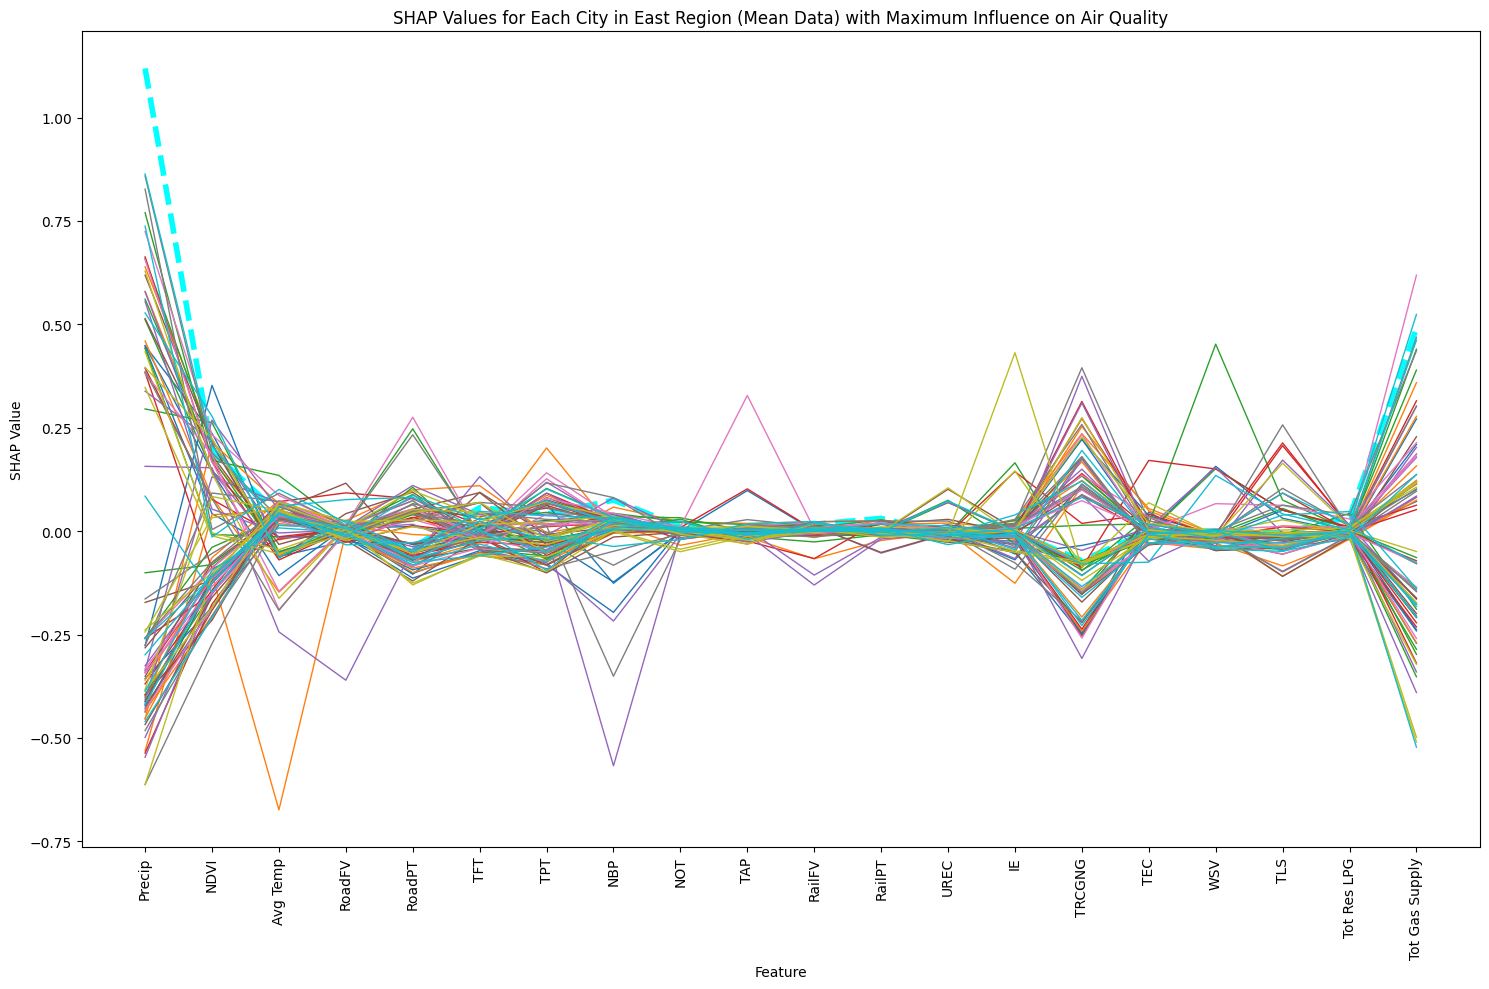

In [5]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 读取 Excel 文件
yaqem_df = pd.read_excel("YAQEM.xlsx")
xne_df = pd.read_excel("XNE.xlsx")
xtn_df = pd.read_excel("XTN.xlsx")
xec_df = pd.read_excel("XEC.xlsx")

# 选择空气质量相关特征进行 PCA 降维
air_quality_features = ["CO", "NO2", "O3", "PM2_5", "PM10", "SO2"]
yaqem_filtered = yaqem_df[air_quality_features].dropna()

scaler = StandardScaler()
yaqem_scaled = scaler.fit_transform(yaqem_filtered)

pca = PCA(n_components=1)
yaqem_pca = pca.fit_transform(yaqem_scaled)

yaqem_df["AirQualityIndex"] = yaqem_pca

# 确保 `year` 列唯一，删除重复列
xne_df = xne_df.loc[:, ~xne_df.columns.duplicated()]
xtn_df = xtn_df.loc[:, ~xtn_df.columns.duplicated()]
xec_df = xec_df.loc[:, ~xec_df.columns.duplicated()]
yaqem_df = yaqem_df.loc[:, ~yaqem_df.columns.duplicated()]

# 直接指定 20 个数据特征列名，并修正 RFV -> RoadFV, RPT -> RoadPT
feature_columns = [
    "Precip", "NDVI", "Avg Temp",  # 自然环境 (XNE)
    "RoadFV", "RoadPT", "TFT", "TPT", "NBP", "NOT", "TAP", "RailFV", "RailPT",  # 交通 (XTN)
    "UREC", "IE", "TRCGNG", "TEC", "WSV", "TLS", "Tot Res LPG", "Tot Gas Supply"  # 能源 (XEC)
]

# 合并 X 数据（自然环境、交通、能源）
x_data = xne_df.merge(xtn_df, on=["city", "year"], how="outer")
x_data = x_data.merge(xec_df, on=["city", "year"], how="outer")

# 确保 `year` 只出现一次
x_data = x_data.loc[:, ~x_data.columns.duplicated()]

# 仅保留指定的 20 个特征
x_data = x_data[["city", "year"] + feature_columns]

# 合并 X 和 Y 数据（使用 left join 确保数据不丢失）
final_data = yaqem_df[["city", "year", "AirQualityIndex", "quyu"]].merge(x_data, on=["city", "year"], how="left")

# 使用 fillna(0) 填充缺失值，确保 X 数据完整
final_data_cleaned = final_data.fillna(0)

# 选择特征和目标变量
X = final_data_cleaned[feature_columns]
Y = final_data_cleaned["AirQualityIndex"]

# 处理非数值列
X = X.select_dtypes(include=[np.number])

# 强制转换所有特征列为数值类型
for col in feature_columns:
    final_data_cleaned[col] = pd.to_numeric(final_data_cleaned[col], errors="coerce")

# 获取东部区域的城市数据
east_region_data = final_data_cleaned[final_data_cleaned["quyu"] == "西部"]

# 按城市计算均值（包括 `AirQualityIndex`）
east_region_avg = east_region_data.groupby("city")[feature_columns + ['AirQualityIndex']].mean()

# 获取东部区域城市的列表
east_region_cities = east_region_avg.index.tolist()

# 获取 SHAP 值
X_filled = east_region_avg[feature_columns].fillna(0)
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X_filled, east_region_avg["AirQualityIndex"])

# 计算 SHAP 值
explainer = shap.Explainer(model, X_filled)
shap_values = explainer(X_filled)

# 绘制 SHAP 值折线图
plt.figure(figsize=(15, 10))

# 定义颜色映射
city_colors = plt.cm.get_cmap("tab10", len(east_region_cities))

# 找到正向影响最大的城市
max_shap_value = -np.inf
max_shap_city = None

# 获取每个城市的最大正向 SHAP 值并选出影响最大的城市
city_max_shap_values = {}

for i, city in enumerate(east_region_cities):
    # 获取该城市的 SHAP 值
    city_shap_values = shap_values.values[i]  # 使用索引 i 获取 SHAP 值
    
    # 确保 city_shap_values 是一个包含 20 个特征的数组
    if city_shap_values.ndim == 1 and len(city_shap_values) == len(feature_columns):
        avg_shap_values = city_shap_values  # SHAP 值本身已经是一个 20 维的数组
    else:
        print(f"警告: {city} 的 SHAP 值维度不匹配，跳过该城市。")
        continue
    
    # 计算每个城市的最大正向 SHAP 值
    city_max_shap_values[city] = np.max(avg_shap_values)

# 按最大 SHAP 值排序，找到最大正向影响的城市
max_shap_city = max(city_max_shap_values, key=city_max_shap_values.get)

# 绘制各个城市的折线
for i, city in enumerate(east_region_cities):
    # 获取该城市的 SHAP 值
    city_shap_values = shap_values.values[i]  # 使用索引 i 获取 SHAP 值
    
    # 确保 city_shap_values 是一个包含 20 个特征的数组
    if city_shap_values.ndim == 1 and len(city_shap_values) == len(feature_columns):
        avg_shap_values = city_shap_values  # SHAP 值本身已经是一个 20 维的数组
    else:
        continue
    
    # 影响最大的城市使用虚线并加粗，颜色为荧光青色
    linestyle = '--' if city == max_shap_city else '-'
    linewidth = 4 if city == max_shap_city else 1  # 加粗影响最大城市的虚线
    color = 'cyan' if city == max_shap_city else city_colors(i)  # 设置最大影响城市的颜色为荧光色
    
    plt.plot(feature_columns, avg_shap_values, color=color, linestyle=linestyle, linewidth=linewidth)

# 设置标题和标签
plt.title("SHAP Values for Each City in East Region (Mean Data) with Maximum Influence on Air Quality")
plt.xlabel("Feature")
plt.ylabel("SHAP Value")
plt.xticks(rotation=90)

# 图例已被移除

plt.tight_layout()
plt.show()
